**CLASE 41 - ALGORITMOS DE CLASIFICACION**
---

In [13]:
#Importacion de Librerias

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.impute import SimpleImputer
import matplotlib.ticker as ticker
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import BinaryEncoder
from category_encoders import HashingEncoder
# Librerías para arboles de decision 
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
# Librerias para regresión logística
import statsmodels.api as sm
import statsmodels.formula.api as smf
# Librería para PCA
from sklearn.decomposition import PCA
# Libreria para KMeans
from sklearn.cluster import KMeans
# Libreria para normalizar
from sklearn.preprocessing import StandardScaler
# Libreria para separar en train y test
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Librería para RandomForest
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# Librerías para métricas
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report,recall_score, f1_score
import scipy 
# Seteo para que no se muestre notación científica
np.set_printoptions(suppress=True)

In [2]:
# Función para calcular métricas
def CalculaMetricas(variable):
    
    # Elimino los vacíos
    variable = variable[variable.isnull() == False]

    media = variable.mean()
    mediana = variable.median()
    media_recortada = scipy.stats.trim_mean(variable,0.1)
    varianza = variable.var()
    desvio = variable.std()
    primer_cuartil = variable.quantile(0.25)
    tercer_cuartil = variable.quantile(0.75)
    percentil_1 = variable.quantile(0.01)
    percentil_99 = variable.quantile(0.99)
    error_estandar = scipy.stats.sem(variable) 
    cv = scipy.stats.variation(variable)
    asimetria = scipy.stats.skew(variable) 
    curtosis = scipy.stats.kurtosis(variable)    
    
    resultado = (
        f'Medidas de Tendencia Central\n'
        f'Media: {round(media, 0)}\n'
        f'Media Recortada: {round(media_recortada, 0)}\n'
        f'Mediana: {round(mediana, 0)}\n\n'
        f'Medidas de Localización\n'
        f'Primer Cuartil: {round(primer_cuartil, 0)}\n'
        f'Tercer Cuartil: {round(tercer_cuartil, 0)}\n'
        f'Percentil 1: {round(percentil_1, 0)}\n'
        f'Percentil 99: {round(percentil_99, 0)}\n\n'
        f'Medidas de Dispersión Absolutas\n'
        f'Varianza: {round(varianza, 0)}\n'
        f'Desvío Estándar: {round(desvio, 0)}\n'
        f'Rango Intercuartílico: {round(tercer_cuartil - primer_cuartil, 0)}\n'
        f'Error Estándar: {round(error_estandar, 0)}\n\n'
        f'Medidas de Dispersión Relativas\n'
        f'Coeficiente de Variación: {round(cv, 2)}\n'
        f'Desvío Intercuartílico: {round((tercer_cuartil - primer_cuartil) / (tercer_cuartil + primer_cuartil), 2)}\n\n'
        f'Medidas de Asimetría y Curtosis\n'
        f'Coeficiente de Asimetría: {round(asimetria, 2)}\n'
        f'Coeficiente de Curtosis: {round(curtosis, 2)}'
    )

    print(resultado)

In [3]:
ruta = '/Users/Gerson/Desktop/Data-Science.'
os.chdir(ruta)

df = pd.read_excel("Amazon_Sales_Report.xlsx")

In [4]:
df.head()

,index,Order ID,Date,Status,Fulfilment,ship-service-level,Style,SKU,Category,Size,...,Qty,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Standard,SET389,SET389-KR-NP-S,Set,S,...,0,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship
1,1,171-9198151-1101146,04-30-22,Shipped,Merchant,Standard,JNE3781,JNE3781-KR-XXXL,kurta,3XL,...,1,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Expedited,JNE3371,JNE3371-KR-XL,kurta,XL,...,1,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Standard,J0341,J0341-DR-L,Western Dress,L,...,0,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Expedited,JNE3671,JNE3671-TU-XXXL,Top,3XL,...,1,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN


In [5]:
df['Courier Status'].fillna('No especificado', inplace=True)
df['ship-city'].fillna('No especificado', inplace=True)
df['ship-state'].fillna('No especificado', inplace=True)
df['ship-postal-code'].fillna('No especificado', inplace=True)
df['ship-country'].fillna('No especificado', inplace=True)
df['promotion-ids'].fillna('No especificado', inplace=True)

df.dropna(subset=['currency', 'Amount'], inplace=True)
df = df[df['Amount'] != 0]

valores_faltantes_columnas = ["B2B", "fulfilled-by"]
datos_faltantes = df[valores_faltantes_columnas].isnull()

imputer = SimpleImputer(strategy='most_frequent')

df[valores_faltantes_columnas] = imputer.fit_transform(df[valores_faltantes_columnas])

# Elimino los guiones de la columna 'Order ID'
df['Order ID'] = df['Order ID'].str.replace('-', '')

# Convierto la columna a tipo numérico
df['Order ID'] = pd.to_numeric(df['Order ID'], errors='coerce')

#convierto el campo date en formato fecha.
df['Date']=pd.to_datetime(df['Date'])

/var/folders/kg/bj4nwrzj2k71bwdyw9wl8ll40000gp/T/ipykernel_1118/2515344036.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'No especificado' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df['ship-postal-code'].fillna('No especificado', inplace=True)
/var/folders/kg/bj4nwrzj2k71bwdyw9wl8ll40000gp/T/ipykernel_1118/2515344036.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date']=pd.to_datetime(df['Date'])


In [6]:
# Creamos el codificador indicandole el orden de la variables
encoder = OrdinalEncoder(categories=[["Set", "kurta", "Western Dress", "Top", "Ethnic Dress", "Blouse", "Bottom", "Saree", "Dupatta"]])

# Ajustamos el codificador con la variable Fulfilment y la transformamos
encoder.fit(df[["Category"]])
df["Categoria_encoded"] = encoder.transform(df[["Category"]])

In [7]:
# Creamos el codificador indicandole el orden de la variables
encoder = OrdinalEncoder(categories=[["Amazon", "Merchant"]])

# Ajustamos el codificador con la variable Fulfilment y la transformamos
encoder.fit(df[["Fulfilment"]])
df["Seller_encoded"] = encoder.transform(df[["Fulfilment"]])

Text(0.5, 1.0, 'Distribución de Amount')

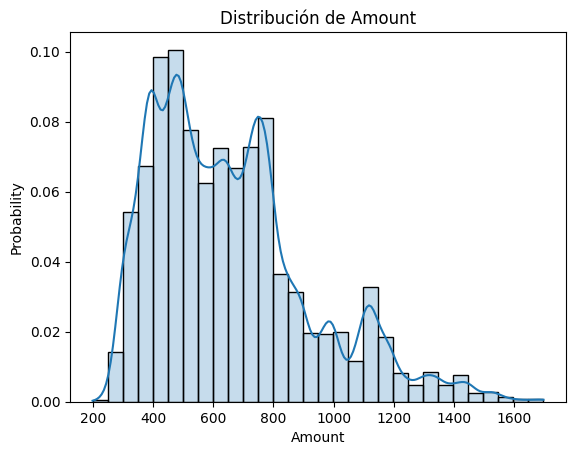

In [8]:
# Distribución de variable Amount
plt.figure()
# Histograma
sns.histplot(data = df,
             x = 'Amount',
             bins = 30,            
             alpha = 0.25,
             kde = True,
             stat='probability')
plt.title('Distribución de Amount')

In [9]:
# Métricas de la variable Amount
CalculaMetricas(df['Amount'])

Medidas de Tendencia Central
Media: 660.0
Media Recortada: 631.0
Mediana: 620.0

Medidas de Localización
Primer Cuartil: 458.0
Tercer Cuartil: 788.0
Percentil 1: 292.0
Percentil 99: 1442.0

Medidas de Dispersión Absolutas
Varianza: 69916.0
Desvío Estándar: 264.0
Rango Intercuartílico: 330.0
Error Estándar: 1.0

Medidas de Dispersión Relativas
Coeficiente de Variación: 0.4
Desvío Intercuartílico: 0.26

Medidas de Asimetría y Curtosis
Coeficiente de Asimetría: 0.96
Coeficiente de Curtosis: 0.63


In [15]:
X = df[['Qty', 'Seller_encoded', 'Categoria_encoded']]
y = df['Amount']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
modelo = LinearRegression()
modelo.fit(X_train, y_train)

LinearRegression()

In [19]:
predicciones = modelo.predict(X_test)

In [20]:
mse = mean_squared_error(y_test, predicciones)
r2 = r2_score(y_test, predicciones)
print(f'Mean Squared Error (MSE): {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error (MSE): 63732.87687128689
R^2 Score: 0.09598250328451685
